This notebook is used to predict missing Flux-data for Göttingen forest and the forst bothanical garden.  
The approach used is an MLP. Be careful to adjust how many cpu cores u want to use during training!

In [9]:
# important  imports
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import fastprogress

from sklearn.preprocessing import MinMaxScaler


In [23]:
# Get number of cpus to use for faster parallelized data loading
avb_cpus = os.cpu_count()
num_cpus = 0
print(avb_cpus, 'CPUs available,', num_cpus, 'were assigned' )

# Device loader from Deep Learning

######## SPECIFY IF YOU DONT WANT TO USE CUDA (GPU) ###########
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

device = get_device()

16 CPUs available, 0 were assigned
cuda available: True ; cudnn available: True ; num devices: 1
Using device NVIDIA GeForce RTX 3070


#  Utilites

In [24]:
############# UTILITIES ############

from modules.util import EBCDataset, grab_data, train_val_test_splitter, data_loaders

# Training Functions

In [25]:
############# TRAINING FUNCTIONS ###############

# Define validation metric
def prediction_error(y, y_pred): 
    #return abs(y - y_pred)
    return 0




def train(dataloader, optimizer, model, master_bar, device, loss_fn = nn.MSELoss()):
    """Run one training epoch.

    Args:
        dataloade: dataloader containing trainingdata
        optimizer: Torch optimizer object
        model: the model that is trained
        loss_fn: the loss function to be used -> nn.MSELoss()
        master_bar: Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        Mean epoch loss and accuracy
    """
    loss = []
    total_prediction_error = 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        # Reset optimmizers
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the prediction error, add the distance between y and y_pred
        # to the total error
        #total_prediction_error += prediction_error(y, y_pred)

        # Compute loss
        epoch_loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        epoch_loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        loss.append(epoch_loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(loss), total_prediction_error





def validate(dataloader, model, master_bar, device, loss_fn=nn.MSELoss()):
    """Compute loss and total prediction error on validation set.

    Args:
        dataloader: dataloader containing validation data
        model (nn.Module): the model to train
        loss_fn: the loss function to be used, defaults to MSELoss
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        Mean loss and total prediction error on validation set
    """
    epoch_loss = []
    total_prediction_error = 0  

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the prediction error, add the distance between y and y_pred
            # to the total error
            #total_prediction_error += prediction_error(y, y_pred)

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), total_prediction_error





def plot(title, label, train_results, val_results, yscale='linear', save_path=None):
    """Plot learning curves.

    Args:
        title: Title of plot
        label: y-axis label
        train_results: Vector containing training results over epochs
        val_results: vector containing validation results over epochs
        yscale: Defines how the y-axis scales
        save_path: Optional path for saving file
    """
    
    epochs = np.arange(len(train_results)) + 1
    
    sns.set(style='ticks')

    plt.plot(epochs, train_results, epochs, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(os.path.join( save_path , label+".png")), bbox_inches='tight')
    plt.show()







def run_training(model, optimizer, num_epochs, train_dataloader, val_dataloader, device, 
                 loss_fn=nn.MSELoss(), verbose=False):
    """Run model training.

    Args:
        model: The model to be trained
        optimizer: The optimizer used during training
        loss_fn: Torch loss function for training -> nn.MSELoss()
        num_epochs: How many epochs the model is trained for
        train_dataloader:  dataloader containing training data
        val_dataloader: dataloader containing validation data
        verbose: Whether to print information on training progress

    Returns:
        lists containing  losses and total prediction errors per epoch for training and validation
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_tpes, val_tpes = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_tpe = train(dataloader=train_dataloader, optimizer=optimizer, model=model, 
                                                 master_bar=master_bar, device=device, loss_fn=loss_fn)
        # Validate the model
        epoch_val_loss, epoch_val_tpe = validate(val_dataloader, model, master_bar, device, loss_fn)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_tpes.append(epoch_train_tpe)
        val_tpes.append(epoch_val_tpe)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_tpe:.3f}, val acc {epoch_val_tpe:.3f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')

    plot("Loss", "Loss", train_losses, val_losses)
    #plot("TPE", "TPE", train_tpes, val_tpes)

    return train_losses, val_losses, train_tpes, val_tpes

# The Multilayer Perceptron

In [26]:
from modules.models import MLP
from columns import COLS_FEATURES, COLS_LABELS, PATH

# The Training

In [27]:
# Collect data and create data loaders
# if COLS_METEO and COLS_FLUXES are changed make sure to run the preprocessing pipeline first
dataset, num_data, num_labels = grab_data('data/training_data_merged.csv', COLS_FEATURES, COLS_LABELS)

trainset, valset, testset = train_val_test_splitter(dataset)


# normalize features based on trainset statistics only
# trainset_mean = torch.mean(trainset.dataset.dataset.data, dim=0)
# trainset_std = torch.std(trainset.dataset.dataset.data, dim=0)

# trainset.dataset.dataset.data = (trainset.dataset.dataset.data - trainset_mean) / trainset_std ** 2
# valset.dataset.dataset.data = (valset.dataset.dataset.data - trainset_mean) / trainset_std ** 2
# testset.dataset.data = (trainset.dataset.dataset.data - trainset_mean) / trainset_std ** 2

labels_std = torch.std(trainset.dataset.dataset.labels, dim=0)
print(labels_std**2)

trainloader, valloader, testloader = data_loaders(trainset, valset, testset, num_cpus=num_cpus, batch_size=10)

tensor([7081.9624, 4335.7935])


Finished training after 17 seconds.


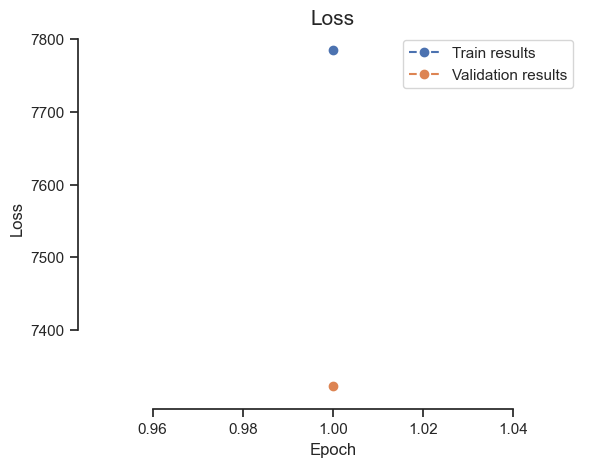

In [21]:
# run single epoch with very low learning rate to check if initial loss is higher than label variance (it should be)
# Initialize the model
model = MLP(num_data, num_labels, num_hidden_units=30, num_hidden_layers=4).to(device)
# Set loss function and optimizer
criterion = nn.MSELoss()
lr = 10**(-5)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 1

train_losses, val_losses, train_tpes, val_tpes = run_training(model=model, optimizer=optimizer, num_epochs=num_epochs, train_dataloader=trainloader, val_dataloader=valloader, 
                                                              device=device, loss_fn=criterion, verbose=True)

Should one model per location be used?

Finished training after 85 seconds.


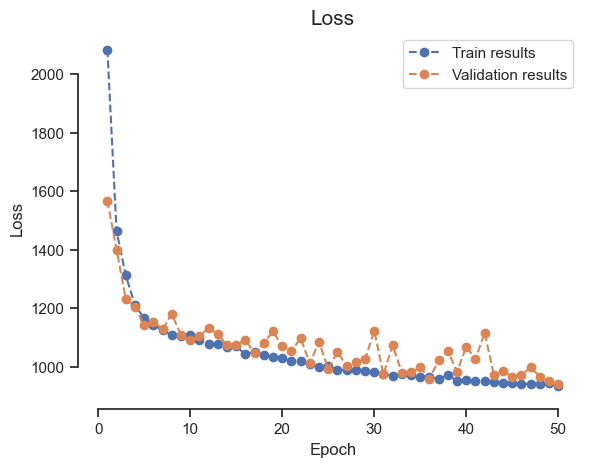

In [30]:
# Initialize the model
model = MLP(num_data, num_labels, num_hidden_units=30, num_hidden_layers=4).to(device)
# Set loss function and optimizer
criterion = nn.MSELoss()
lr = 10**(-3)
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 50

train_losses, val_losses, train_tpes, val_tpes = run_training(model=model, optimizer=optimizer, num_epochs=num_epochs, train_dataloader=trainloader, val_dataloader=valloader, 
                                                              device=device, loss_fn=criterion, verbose=True)

In [65]:
# Save the model
torch.save(model.state_dict(), 'model_saves/mlp_1.pth' )